# Bagging

This notebook introduces a very natural strategy to build ensembles of machine learning models named "bagging".

"Bagging" stands for Bootstrap AGGregarING. It uses bootstrap resampling (random sampling with replacement) to learn several models on random variations of the training set. At predict time, the predictions of each learner are aggregated to give the final predictions.

First, we will generate a simple synthetic dataset to get insights regarding bootstraping:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a random number generator
rng = np.random.RandomState(1)

def generate_data(n_samples=30):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

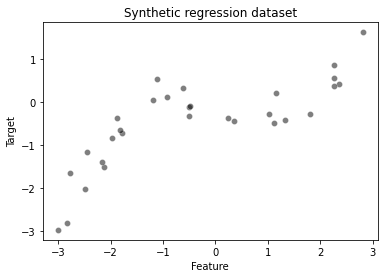

In [3]:
data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")

The relationship between our feature and the target to predict is non-linear. However, a decision tree is capable of approximating such a non-linear dependency:

In [4]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)
y_pred = tree.predict(data_test)

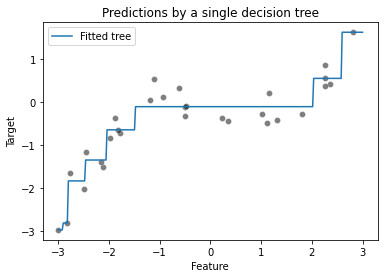

In [5]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
plt.plot(data_test, y_pred, label="Fitted tree")
plt.legend()
_ = plt.title("Predictions by a single decision tree")

Let's see how we can use bootstraping to learn several trees.

## Bootstrap resampling

A bootstrap sample corresponds to resampling with replacement, of the original dataset, a sample that is the same size as the original dataset. Thus, the bootstrap sample will contain some data points several times while some of the original data points will not be present.

We will create a function that given data and target will retrun a resampled variation `data_bootstrap` and `target_bootstrap`.

In [6]:
def bootstrap_sample(data, target):
    # Indices corresponding to a sampling with replacement of the same sample
    # size than the original data
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]), size=target.shape[0], replace=True,
    )
    # In pandas, we need to use `.iloc` to extract rows using an integer
    # position index:
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

We will generate 3 bootstrap samples and qualitatively check the difference with the original dataset.

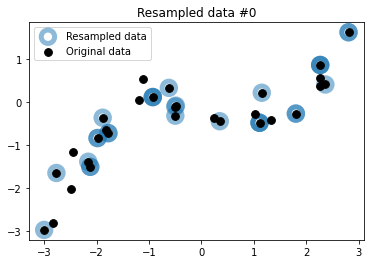

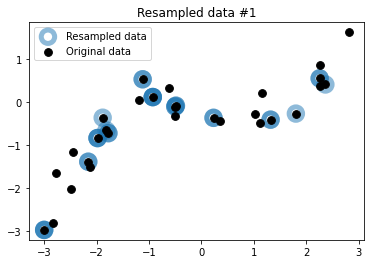

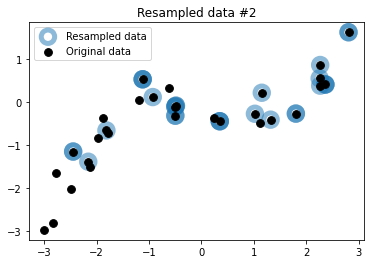

In [7]:
n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    # draw a bootstrap from the original data
    data_bootstrap, target_bootstrap = bootstrap_sample(
    data_train, target_train)
    plt.figure()
    plt.scatter(data_bootstrap['Feature'], target_bootstrap,
               color="tab:blue", facecolors="none", 
               alpha=.5, label='Resampled data', s=180,
               linewidth=5)
    plt.scatter(data_train["Feature"], target_train,
                color="black", s=60,
                alpha=1, label="Original data")
    plt.title(f"Resampled data #{bootstrap_idx}")
    plt.legend()

Observe that the 3 variations all share common points with the original dataset. Some of the points are randomly resampled several times and appear as darker blue circles.  

The 3 generated bootstrap samples are all different from the original dataset and from each other. To confirm this intuition, we can check the number of unique samples in the bootstrap samples

In [8]:
data_train_huge, data_test_huge, target_train_huge = generate_data(
    n_samples=100_000)
data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
    data_train_huge, target_train_huge)

ratio_unique_sample = (np.unique(data_bootstrap_sample).size /
                       data_bootstrap_sample.size)
print(
    f"Percentage of samples present in the original dataset: "
    f"{ratio_unique_sample * 100:.1f}%"
)

Percentage of samples present in the original dataset: 63.2%


On average, ~63\% of the original data points of the original dataset will be present in a given bootstrap sample. The other ~36\% are repeated samples.  

We are able to generate many datasets, all slightly different.

Now, we can fit a decision tree for each of these datasets and they all shall be slightly different as well.

In [9]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)
    data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(data_train,
                                                                     target_train)
    tree.fit(data_bootstrap_sample, target_bootstrap_sample)
    bag_of_trees.append(tree)

Now that we created a bag of different trees, we can use each of the tree to predict on the testing data. They shall give slightly different predictions.

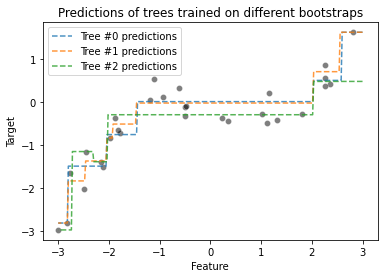

In [10]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test, tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")

plt.legend()
_ = plt.title("Predictions of trees trained on different bootstraps")